## Detecting Credit Card Fraud with a Random Forest Classifier in Python
#### Christianna Lindsay

In this exercise, we will implement a random forest classifier in Python to predict credit card fraud. A random forest is an ensemble learning method that can perform regression or classification. In this case, we want to classify a transaction as 'valid' or 'fraud.' Random forest combines predictions from multiple decision trees to reduce variance and increase the accuracy of predictions.

This dataset is from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) and contains information on European credit card transactions over a two-day period from September 2013. The features 'V1', ... , 'V28' are numeric principal components obtained from PCA, which were transformed for the sake of maintaining confidentiality. There are also two un-transformed predictors, 'Time' and 'Amount', which are, respectively, the seconds elapsed since the first transaction and the transaction amount. The response variable, 'Class', takes value 0 for a valid transaction and 1 for a fraudulent transaction.

The transformation of the numeric variables makes it impossible to interpret the effects of individual variables on the likelihood of a transaction being fraud. We will see that we can still create an effective model to predict fraudulent transactions, but our model would be more interpretable if we had access to the un-transformed predictor variables. 

In [102]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

### Load the Data

In [4]:
#load the dataset using pandas
data = pd.read_csv("creditcard.csv")

### View the Data

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Understand the Data

From the following output we see that we have 284,807 transactions with 31 total variables. All of the predictor variables are numeric.

In [6]:
print(data.shape)
print(data.describe())

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271

Before we train our model, it's a good idea to assess how balanced our data set is -- that is, what proportion of the transactions are fraudulent vs. valid.

In [19]:
fraud = data[data['Class']==1]
not_fraud = data[data['Class']==0]
fraud_fraction = len(fraud)/float(len(not_fraud))
print('Number of fraud cases: {}'.format(len(data[data['Class'] == 1])))
print('Number of valid transactions: {}'.format(len(data[data['Class'] == 0])))
print("Percent of fraud cases: {}".format(fraud_fraction*100)+"%")

Number of fraud cases: 492
Number of valid transactions: 284315
Percent of fraud cases: 0.17304750013189596%


We see that only 0.17% of the transactions are fraud, which means we have an incredibly imbalanced data set. This is a problem because a machine learning technique might acheive a high accuracy rate by simply ignoring the minority class (the fraud cases). For instance, we could create a model achieving 99.83% accuracy by simply predicting that every transaction is valid. Unfortunately, that would be a rather useless model because we care most acutely about the 0.17% of transactions which are fraud. 

### Achieve Balance by Undersampling

To remedy this problem, we will perform weighted resampling to obtain a more balanced data set in terms of the valid vs. fraudulent cases, and therefore create a model that is better at predicting fraud. Specifically, we will apply a technique called undersampling, where we select a random subset of the valid transactions to keep, so there are an equal number of valid and fraudulent cases.

Before we balance the dataset, we'll divide it into an 80-20 training-testing split.

In [64]:
# Categorize variables as X or y
X = data.drop('Class', axis=1) #predictors
y = data['Class'] #response variable

# Divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2)

Next we can create a RandomUnderSampler object and apply the fit_resample function to create a balanced dataset.

In [65]:
RUS = RandomUnderSampler(random_state=25, sampling_strategy='majority')
X_train_resampled, y_train_resampled = RUS.fit_resample(X_train, y_train)

In [66]:
train_fraud_frac = sum(y_train_resampled==0)/len(y_train_resampled)
print("Percent of fraud cases in resampled testing set: {}".format(train_fraud_frac*100)+"%")

Percent of fraud cases in resampled testing set: 50.0%


The resampled training set now contains 50% fraud and 50% valid cases. The testing set was not undersampled because we want it to reflect the true proportion of valid vs. fraud cases.

### Build the Random Forest Model

In [89]:
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)

### Evaluate the Model

To evaluate the performance of our model, we'll consider several metrics--specifically, the accuracy, precision, recall, and F1 score.

In [100]:
num_fraud = len(fraud)
num_errors = (y_pred != y_test).sum()
print("Random Forest Classifier (Balanced Training Set)")

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))

precision = precision_score(y_test, y_pred)
print("Precision: {}".format(precision))

recall = recall_score(y_test, y_pred)
print("Recall: {}".format(recall))

Random Forest Classifier (Balanced Training Set)
Accuracy: 0.9724728766546118
Precision: 0.05562273276904474
Recall: 0.9387755102040817


Accuracy is the number of correct classifications divided by the total number of classifications.

Precision is the correctly classified actual positives divided by the everything classified as positive.

Recall is the correctly classified actual positives divided by all actual positives. In this case, we care more about recall, since we really want to catch all of the positive cases of fraud.

Let's look at a confusion matrix to more easily visualize where the misclassifications are happening. Note that the diagonals are correct classifications, while the off-diagonals are the misclassifications.

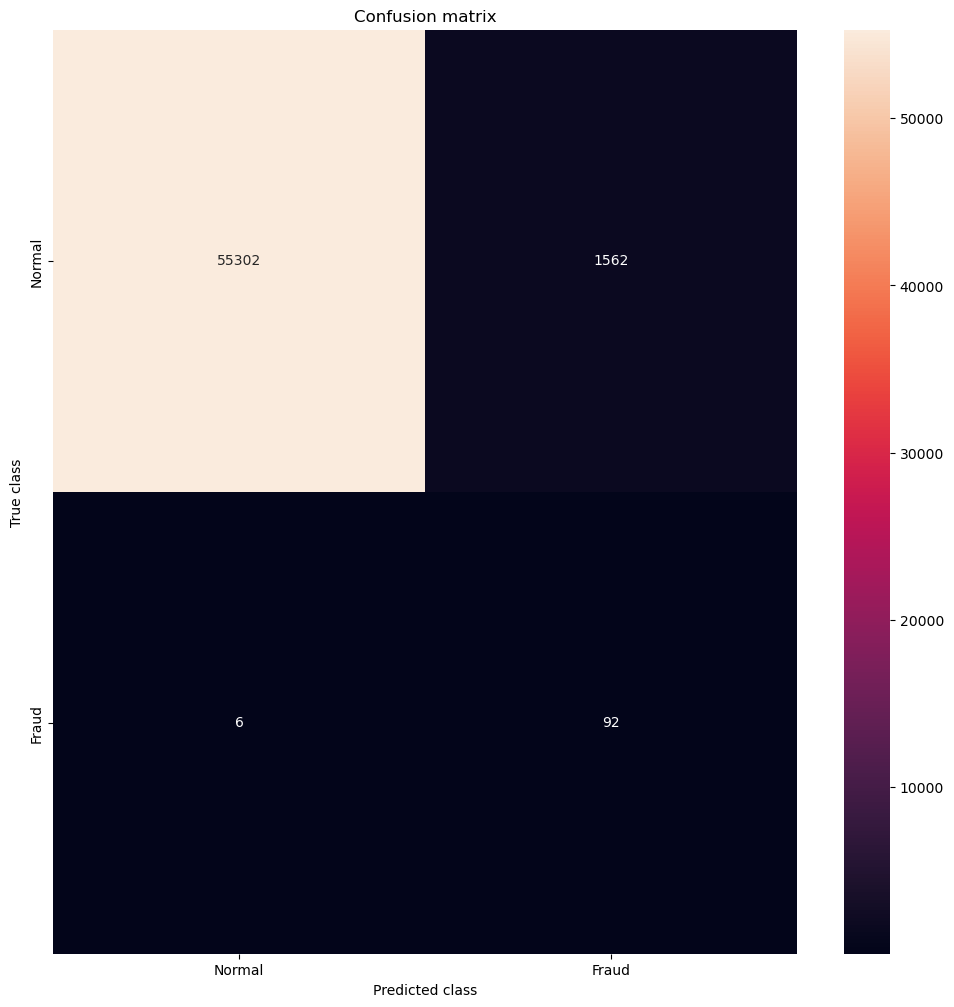

In [93]:
#confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize =(12, 12))
sns.heatmap(conf_matrix, xticklabels = LABELS, 
            yticklabels = LABELS, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

We see that most of the misclassifications are false positives. In fact, the vast majority of the cases classified as fraud are false positives (this is the precision).

### Compare with Performance on the Imbalanced Dataset

For the sake of comparison, let's rerun our random forest classifier, but without undersampling the training set first.

In [94]:
rf_imb = RandomForestClassifier()
rf_imb.fit(X_train, y_train)
y_pred_imb = rf_imb.predict(X_test)

This time the model takes significantly longer to train, since we are using the 80% of the full dataset for training, rather than 80% of the undersampled dataset.

In [103]:
num_fraud = len(fraud)
num_errors = (y_pred_imb != y_test).sum()
print("Random Forest Classifier (Imbalanced Training Set):")

accuracy = accuracy_score(y_test, y_pred_imb)
print("Accuracy: {}".format(accuracy))

precision = precision_score(y_test, y_pred_imb)
print("Precision: {}".format(precision))

recall = recall_score(y_test, y_pred_imb)
print("Recall: {}".format(recall))

f1 = f1_score(y_test, y_pred_imb)
print("F1-Score: {}".format(f1))

Random Forest Classifier (Imbalanced Training Set):
Accuracy: 0.9996313331694814
Precision: 0.9753086419753086
Recall: 0.8061224489795918
F1-Score: 0.88268156424581


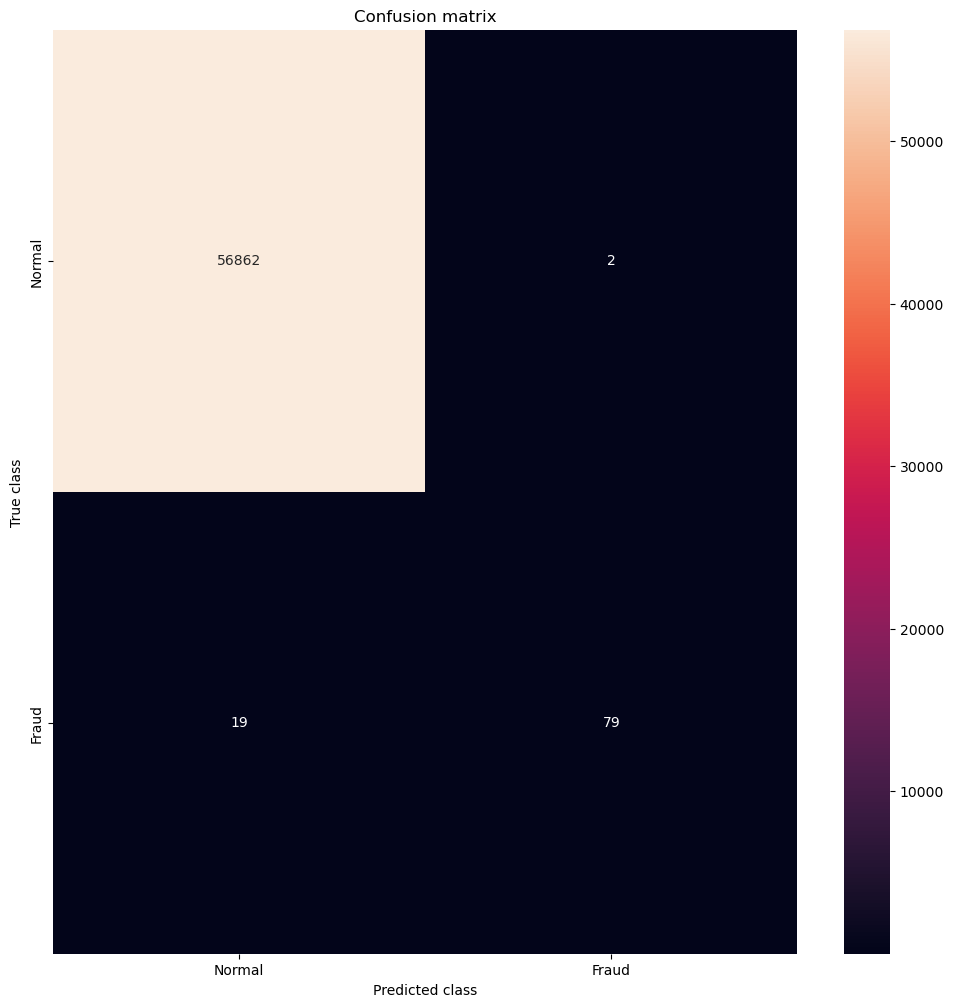

In [99]:
#confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred_imb)
plt.figure(figsize =(12, 12))
sns.heatmap(conf_matrix, xticklabels = LABELS, 
            yticklabels = LABELS, annot = True, fmt ="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

While the total accuracy increases using the full dataset (from 97.24% to 99.96%), and the precision increases dramatically (from 5.56% to 97.53%), the recall also decreases substantially (from 93.88% to 80.61%). What this means is that the model trained on the balanced dataset is better at catching the fraud cases but it's also worse about flagging false positives. Depending on how expensive false positives are versus false negatives, a credit card company may prefer one model over the other.